# Теория стилизации изображений (Neural Style Transfer)

Рассмотрим довольно популярную технику переноса стиля от одного изображения к другому:
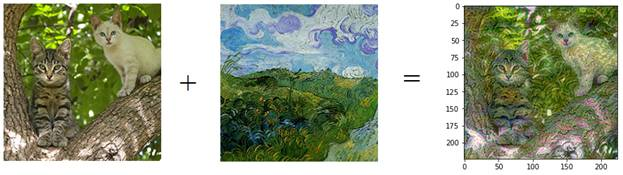
В англоязычной литературе это называется: <b>Neural Style Transfer</b>.

Существует множество вариантов таких алгоритмов, но мы поговорим о наиболее простом, предложенном <b>Леоном Гатисом</b> в <b>2015-м</b> году.

Идея такая. Взять исходное изображение (котики) и рассматривать его пиксели, как настраиваемые параметры в алгоритме градиентного спуска. Критерий качества должен быть выбран так, чтобы он уменьшался по мере приближения исходного изображения к желаемому стилизованному:
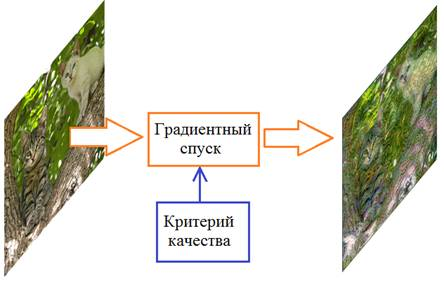

Как видите, общая идея предельно проста. И, вроде бы, здесь даже нет никакой НС? Все верно, можно обойтись и без нее. 

Но, с нейросетью проще: именно она позволяет «понимать» степень стилизации и корректность стилизации. Другими алгоритмами получить эту оценку крайне сложно. 

То есть, НС используется при вычислении критерия качества стилизованного изображения. И лучшими здесь являются сверточные НС. Фактически, критерий качества является ключевым элементом данного алгоритма, поэтому мы с него и начнем.

В своей работе Леон Гатис разделил общий критерий качества на две независимые оценки:
<b>
- степень соответствия преобразованного изображения исходному;
- степень стилизации преобразованного изображения.
</b>

Эти величины вычисляются независимо друг от друга, а затем, суммируются с определенными весами для формирования общего показателя качества.

### Начнем с первой оценки.

Как понять: насколько отличаются два изображения? 

В классических алгоритмах обработки изображений часто использовалась сумма квадратов рассогласований между отдельными пикселями:
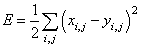

Но, для данной задачи, она не очень подходит, так как не учитывает структуру изображения, например, линии, овалы, глаза, лапы, ветки и т.п.

Чтобы оценивать изображения на более абстрактном уровне, как раз и используется НС. В рамках нашей задачи мы воспользуемся уже готовой сверточной НС VGG19. Причем, мы ее будем использовать с уже обученными весами связей, которые были получены по базе изображений ImageNet, состоящей, примерно, из 10 миллионов различных полноцветных изображений. 

Что нам это дает? Глубокие слои обученной сверточной НС как раз описывают изображение набором общих признаков: голова, хвост, трава, тело и т.п. Это как раз то, что нам сейчас и нужно.

Мы возьмем один из последних слоев сети VGG19 и вычислим сумму разности квадратов признаков:
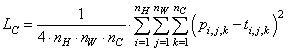
Здесь:
- $\{p_{i, j, k}\}$ - набор признаков для формируемого изображения; 
- $\{t_{i, j, k}\}$ - набор признаков для исходного изображения (с котиками);
- $n_H, n_w$ - высота и ширина карты признаков (в нашем случае $14 \times 14$); 
- $n_C$ - число каналов ($n_C = 512$). 
- Множитель перед суммой используется для нормировки, усреднения полученной величины. 

То есть, мы делаем следующее. Пропускаем через сеть VGG19 исходное изображение, получаем на последнем слое набор признаков $\{t_{i, j, k}\}$. Затем, пропускаем модифицированное изображение, получаем признаки $\{p_{i, j, k}\}$. И, потом, вычисляем показатель качества  для контента.

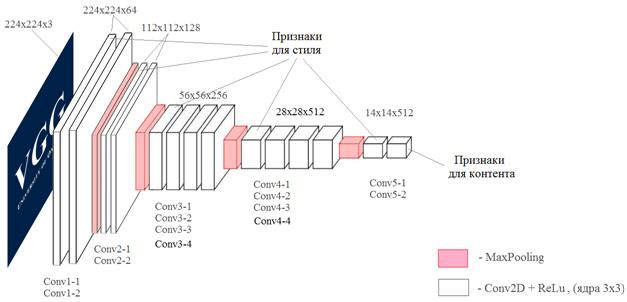

### Перейдем ко второму – степени стилизации формируемого изображения.

Это более сложный признак: уловить абстракцию стиля и потом еще оценить его сходство – было непосильной задачей вплоть до появления глубоких НС. Поэтому здесь мы снова воспользуемся сетью VGG19, чтобы с ее помощью уловить эфемерный параметр степени стилизации.

Для начала нам нужно прогнать стилевое изображение через НС. И, далее, рассмотрим тензор предпоследнего слоя Conv5-1. Вытянем его в матрицу для удобства дальнейших вычислений:
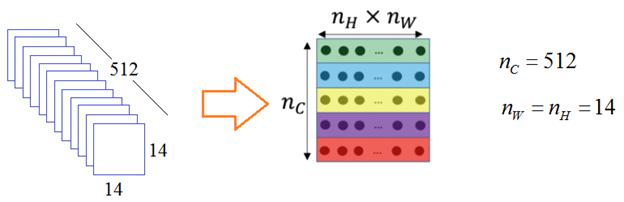

Что теперь сделать с набором этих признаков, для получения числовых характеристик стиля изображения? Однозначного ответа на этот вопрос нет. 
Здесь исследователю нужно включить «здравый смысл», фантазию и попробовать построить некий математический алгоритм. 

Леон Гатис предлагает вначале перемножить полученную матрицу саму себя в транспонированном виде. На выходе получается матрица Грама:
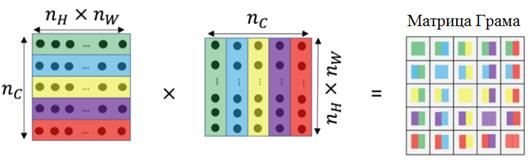

Фактически, эта матрица содержит скалярные произведения векторов признаков для разных каналов. По главной диагонали стоят скалярные произведения векторов с самим собой, принадлежащих разным каналам. А другие элементы – это скалярные произведения векторов между разными каналами. 

В чем магия скалярного произведения? Скалярное произведение определяется как:

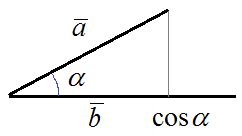

То есть, это проекция одного вектора на другой и это можно воспринимать как меру их схожести. В результате матрица Грама характеризует схожесть признаков между разными каналами. Это и будет характеристика стиля на текущем слое сети VGG19.

Теперь, чтобы понять насколько сильно различаются стили между формируемым изображением и стилизованным, мы пропустим через НС уже формируемое изображение (до этого пропускали стилизованное) и для него тоже вычислим матрицу Грама. В результате, получим:

- $G^P$ - матрица Грама для формируемого изображения;
- $G^S$ - матрица Грама для изображения стилей.

Имея эти матрицы, величину рассогласования стилей на текущем слое НС, можно вычислить по уже знакомой нам формуле:
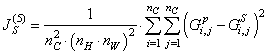
Фактически, мы здесь вычислили квадрат евклидового расстояния между матрицами Грама. А индекс (5) вверху означает, что мы выполнили это вычисление на слое <b>Conv5-1</b>.

Будет ли достаточно этой величины для определения степени различия между стилями изображений? Не совсем.

Стиль, в отличие от объектов (кошек, головы, хвоста, дерева, ветвей, травы и т.п.), имеет важные детали на разных уровнях абстракции. Поэтому для него нужно повторить рассмотренные операции для и начальных слоев: <b>Conv1-1, Conv2-1, Conv3-1, Conv4-1</b>.

В результате, у нас будут величины:

которые, затем, складываются с определенными весами:
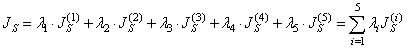
В рамках нашей задачи вы возьмем эти коэффициенты, равные
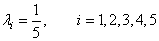
то есть, попросту, усредним показатели качества для разных слоев.

Все, расхождение по стилю определили. Также у нас есть расхождение по контенту.

### Общий показатель качества

Через эти параметры общий показатель качества можно определить в виде:

где $\alpha, \beta$ - некоторые веса, которые показывают насколько важно учитывать содержимое или стиль. 

Подбирая эти значения можно получать разную степень стилизации формируемого изображения.

### Обучение

Далее, поняв, как определятся критерий качества, уже используется алгоритм градиентного спуска, который меняет пиксели исходного изображения (с котиками) так, чтобы минимизировать этот показатель $J$:
